In [ ]:
# HIDE OUTPUT
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [ ]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from gym.wrappers import Monitor

# Experience replay (Replay Memory)

In [ ]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"
    def push(self, state, action, next_state, reward):
        self.memory.append((state,action,next_state,reward))
    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples
    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

Test if it works as expected.

# Network definition

In [ ]:
class DQN(nn.Module):
    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()
        self.linear = nn.Sequential(
                nn.Linear(state_space_dim,128),nn.Tanh(),nn.Linear(128,128),
                nn.Tanh(),nn.Linear(128,action_space_dim),)
    def forward(self, x):
        return self.linear(x)

In [ ]:
# Define an example network
net = DQN(state_space_dim=4, action_space_dim=2)

# Policy network

The policy network takes a state as input, and provides the Q-value for each of the possible actions.

Let's define a simple generic fully-connected feed forward network with `state_space_dim` inputs and `action_space_dim` outputs (e.g. 2 hidden layers with 128 neurons each) with an activation function (e.g. Tanh). 

Be sure to keep a linear output activation.

## Exploration Policy

### Epsilon-greedy policy


With an epsilon-greedy policy we choose a **non optimal** action with probability epsilon, otherwise choose the best action (the one corresponding to the highest Q-value).

In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon):
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)
    best_action = int(net_out.argmax())
    action_space_dim = net_out.shape[-1]
    if random.random() < epsilon:
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]# this has only one element
        action = random.choice(non_optimal_actions)
    else:
        action = best_action
    return action, net_out.numpy()

### Softmax policy

In [ ]:
def choose_action_softmax(net, state, temperature):
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)
    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1]) # output of this line : [0,1]
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    return action, net_out.numpy()

### Exploration profile

Let's consider, for example, an exponentially decreasing exploration profile using a softmax policy.

$$
\text{softmax_temperature}  = \text{initial_temperature} * \text{exp_decay}^i \qquad \text{for $i$ = 1, 2, ..., num_iterations } 
$$

Alternatively, you can consider an epsilon greedy policy. In this case the exploration would be controlled by the epsilon parameter, for which you should consider a different initial value (max 1). 

In [ ]:
### Define exploration profile
initial_value = 5
num_iterations = 2200
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 5) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

# Network update

## Initialization

In this case we will use the Huber loss as loss function (https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html). The Huber loss uses a squared term if the absolute element-wise error falls below beta and an L1 term otherwise. It is less sensitive to outliers than the MSELoss and in some cases prevents exploding gradients.

In [ ]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
### PARAMETERS
gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training
BreakNum = 30

## Update function

In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):   
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)# elements that are True or False
    policy_net.train()
    q_values = policy_net(states)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape
    loss = loss_fn(state_action_values, expected_state_action_values)
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()
    return loss

# Comparison of Softmax and Epsilon greedy policy
In the following part the agent is trained using these two policies.
for epsilon greedy policy two strategies were explored.

1- Usign decaying epsilon (for this part normalized exploration_profile variable is used)

2- Using a constant epsilon (epsilon = 0.09) 

During the training if last 30 trials reach maximum value the training loop is finished

## Softmax policy
Reward is not updated

In [ ]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
replay_mem = ReplayMemory(replay_memory_capacity)    
policy_net = DQN(state_space_dim=4, action_space_dim=2)
target_net = DQN(state_space_dim=4, action_space_dim=2)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network
loss_fn = nn.SmoothL1Loss()

In [ ]:
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)
Loss = []
RewardSoftMax = []
for episode_num, tau in enumerate(tqdm(exploration_profile)):
    state = env.reset()
    score = 0
    done = False
    while not done:
        action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
        next_state, reward, done, info = env.step(action)
        score += 1
        if done: # if the pole has fallen down 
            reward += bad_state_penalty
            next_state = None
        replay_mem.push(state, action, next_state, reward)
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            temp = update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)
            Loss.append(temp)
#         env.render()
        state = next_state
    RewardSoftMax.append(score)
    if(np.mean(RewardSoftMax[-BreakNum:]) > 498):
        print("-------------- break -----------------")
        break
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
env.close()

  0%|          | 0/2200 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.981744341064974
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.9635553359465785
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.9454327412829455
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.927376314600751
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 4.9093858143119755
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 4.891460999710669
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 4.87360163096973
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.855807469137695
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.83807827613555
Updating target network...
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.8204138147535325
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.8028138486479675
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.7852781423380994
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.767806461202948
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.750398571478161
EPISODE: 16 - FINAL 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  after removing the cwd from sys.path.


EPISODE: 44 - FINAL SCORE: 35 - Temperature: 4.272298336865217
EPISODE: 45 - FINAL SCORE: 18 - Temperature: 4.256699612603919
EPISODE: 46 - FINAL SCORE: 23 - Temperature: 4.241157841340609
EPISODE: 47 - FINAL SCORE: 20 - Temperature: 4.225672815132383
EPISODE: 48 - FINAL SCORE: 16 - Temperature: 4.2102443267955705
EPISODE: 49 - FINAL SCORE: 26 - Temperature: 4.194872169902949
EPISODE: 50 - FINAL SCORE: 14 - Temperature: 4.179556138780993
Updating target network...
EPISODE: 51 - FINAL SCORE: 52 - Temperature: 4.164296028507117
EPISODE: 52 - FINAL SCORE: 17 - Temperature: 4.149091634906935
EPISODE: 53 - FINAL SCORE: 37 - Temperature: 4.13394275455153
EPISODE: 54 - FINAL SCORE: 14 - Temperature: 4.118849184754726
EPISODE: 55 - FINAL SCORE: 18 - Temperature: 4.103810723570389
EPISODE: 56 - FINAL SCORE: 43 - Temperature: 4.088827169789708
EPISODE: 57 - FINAL SCORE: 20 - Temperature: 4.073898322938518
EPISODE: 58 - FINAL SCORE: 17 - Temperature: 4.059023983274611
EPISODE: 59 - FINAL SCORE: 1

KeyboardInterrupt: ignored

In [ ]:
env.close()

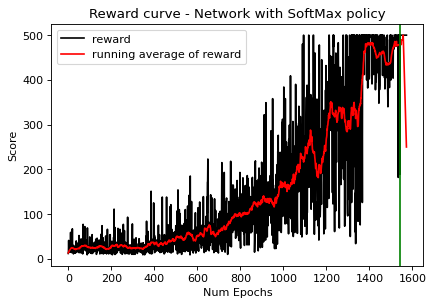

In [ ]:
n = 30
shifted = []
rc = np.convolve(np.ones(n),RewardSoftMax)
for i,r in enumerate(rc):
    if i>= n/2:
        shifted.append(r/n)
    if i + n/2 == len(rc):
        break
plt.figure(figsize=(6,4), dpi=80)
plt.plot(RewardSoftMax,c = 'k',label='reward')
# plt.plot(rc/n)
plt.plot(shifted, c = 'r',label='running average of reward')
plt.axvline(len(RewardSoftMax) - BreakNum ,c='g')
plt.xlabel('Num Epochs')
plt.ylabel('Score')
plt.title('Reward curve - Network with SoftMax policy')
plt.legend()


## Epsilon policy 

### Decaying Epsilon greedy policy

In [ ]:
replay_mem = ReplayMemory(replay_memory_capacity)    
policy_net = DQN(4, 2)
target_net = DQN(4, 2)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network
loss_fn = nn.SmoothL1Loss()

In [ ]:
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)
Loss = []
RewardEpsilon = []
print(exploration_profile)
for episode_num, tau in enumerate(tqdm(exploration_profile)):
    state = env.reset()
    score = 0
    done = False
    while not done:
        action, q_values = choose_action_epsilon_greedy(policy_net, state,epsilon=tau/5)
        next_state, reward, done, info = env.step(action)
        score += 1
        if done: # if the pole has fallen down 
            reward += bad_state_penalty
            next_state = None
        replay_mem.push(state, action, next_state, reward)
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            temp = update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)
            Loss.append(temp)
#         env.render()
        state = next_state
    RewardEpsilon.append(score)
    if(np.mean(RewardEpsilon[-BreakNum:]) > 498):
        print("-------------- break -----------------")
        break
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score}") # Print the final score
env.close()

[5.0, 4.981744341064974, 4.9635553359465785, 4.9454327412829455, 4.927376314600751, 4.9093858143119755, 4.891460999710669, 4.87360163096973, 4.855807469137695, 4.83807827613555, 4.8204138147535325, 4.8028138486479675, 4.7852781423380994, 4.767806461202948, 4.750398571478161, 4.733054240252893, 4.715773235466687, 4.698555325906366, 4.681400281202947, 4.664307871828552, 4.647277869093341, 4.630310045142449, 4.61340417295294, 4.596560026330769, 4.579777379907755, 4.563056009138567, 4.546395690297716, 4.529796200476567, 4.513257317580352, 4.496778820325201, 4.4803604882351795, 4.464002101639342, 4.447703441668789, 4.43146429025374, 4.415284430120616, 4.399163644789134, 4.383101718569407, 4.367098436559061, 4.35115358464036, 4.3352669494773375, 4.319438318512948, 4.303667479966217, 4.287954222829413, 4.272298336865217, 4.256699612603919, 4.241157841340609, 4.225672815132383, 4.2102443267955705, 4.194872169902949, 4.179556138780993, 4.164296028507117, 4.149091634906935, 4.13394275455153, 4.1

  0%|          | 0/2200 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 9
EPISODE: 2 - FINAL SCORE: 10
EPISODE: 3 - FINAL SCORE: 10
EPISODE: 4 - FINAL SCORE: 8
EPISODE: 5 - FINAL SCORE: 10
EPISODE: 6 - FINAL SCORE: 9
EPISODE: 7 - FINAL SCORE: 9
EPISODE: 8 - FINAL SCORE: 10
EPISODE: 9 - FINAL SCORE: 10
EPISODE: 10 - FINAL SCORE: 9
Updating target network...
EPISODE: 11 - FINAL SCORE: 11
EPISODE: 12 - FINAL SCORE: 9
EPISODE: 13 - FINAL SCORE: 11
EPISODE: 14 - FINAL SCORE: 10
EPISODE: 15 - FINAL SCORE: 8
EPISODE: 16 - FINAL SCORE: 10
EPISODE: 17 - FINAL SCORE: 9
EPISODE: 18 - FINAL SCORE: 11
EPISODE: 19 - FINAL SCORE: 10
EPISODE: 20 - FINAL SCORE: 9
Updating target network...
EPISODE: 21 - FINAL SCORE: 12
EPISODE: 22 - FINAL SCORE: 9
EPISODE: 23 - FINAL SCORE: 10
EPISODE: 24 - FINAL SCORE: 9
EPISODE: 25 - FINAL SCORE: 11
EPISODE: 26 - FINAL SCORE: 13
EPISODE: 27 - FINAL SCORE: 9
EPISODE: 28 - FINAL SCORE: 12
EPISODE: 29 - FINAL SCORE: 10
EPISODE: 30 - FINAL SCORE: 9
Updating target network...
EPISODE: 31 - 

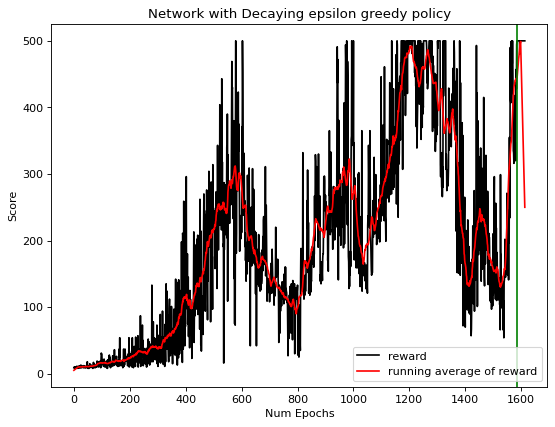

In [ ]:
n = 30
shiftedEpsilon = []
epsilonAverage = np.convolve(np.ones(n),RewardEpsilon)
for i,r in enumerate(epsilonAverage):
    if i>= n/2:
        shiftedEpsilon.append(r/n)
    if i + n/2 == len(epsilonAverage):
        break
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(RewardEpsilon,c = 'k',label='reward')
# plt.plot(rc/n)
plt.plot(shiftedEpsilon, c = 'r',label='running average of reward')
plt.xlabel('Num Epochs')
plt.ylabel('Score')
plt.title('Network with Decaying epsilon greedy policy')
plt.axvline(len(RewardEpsilon) - BreakNum ,c='g')
plt.legend()


### Epsilon greedy policy
here we use constant number for epsilon (0.09)

In [ ]:
replay_mem = ReplayMemory(replay_memory_capacity)    
policy_net = DQN(4, 2)
target_net = DQN(4, 2)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network
loss_fn = nn.SmoothL1Loss()

In [ ]:
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)
Loss = []
RewardEpsilonConstan = []
print(exploration_profile)
for episode_num, tau in enumerate(tqdm(exploration_profile)):
    state = env.reset()
    score = 0
    done = False
    while not done:
        action, q_values = choose_action_epsilon_greedy(policy_net, state,epsilon=0.09)
        next_state, reward, done, info = env.step(action)
        score += 1
        if done: # if the pole has fallen down 
            reward += bad_state_penalty
            next_state = None
        replay_mem.push(state, action, next_state, reward)
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            temp = update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)
            Loss.append(temp)
#         env.render()
        state = next_state
    RewardEpsilonConstan.append(score)
    if(np.mean(RewardEpsilonConstan[-BreakNum:]) > 499):
        print("-------------- break -----------------")
        break
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score}") # Print the final score
env.close()

[5.0, 4.981744341064974, 4.9635553359465785, 4.9454327412829455, 4.927376314600751, 4.9093858143119755, 4.891460999710669, 4.87360163096973, 4.855807469137695, 4.83807827613555, 4.8204138147535325, 4.8028138486479675, 4.7852781423380994, 4.767806461202948, 4.750398571478161, 4.733054240252893, 4.715773235466687, 4.698555325906366, 4.681400281202947, 4.664307871828552, 4.647277869093341, 4.630310045142449, 4.61340417295294, 4.596560026330769, 4.579777379907755, 4.563056009138567, 4.546395690297716, 4.529796200476567, 4.513257317580352, 4.496778820325201, 4.4803604882351795, 4.464002101639342, 4.447703441668789, 4.43146429025374, 4.415284430120616, 4.399163644789134, 4.383101718569407, 4.367098436559061, 4.35115358464036, 4.3352669494773375, 4.319438318512948, 4.303667479966217, 4.287954222829413, 4.272298336865217, 4.256699612603919, 4.241157841340609, 4.225672815132383, 4.2102443267955705, 4.194872169902949, 4.179556138780993, 4.164296028507117, 4.149091634906935, 4.13394275455153, 4.1

  0%|          | 0/2200 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 11
EPISODE: 2 - FINAL SCORE: 9
EPISODE: 3 - FINAL SCORE: 9
EPISODE: 4 - FINAL SCORE: 12
EPISODE: 5 - FINAL SCORE: 13
EPISODE: 6 - FINAL SCORE: 9
EPISODE: 7 - FINAL SCORE: 10
EPISODE: 8 - FINAL SCORE: 13
EPISODE: 9 - FINAL SCORE: 9
EPISODE: 10 - FINAL SCORE: 10
Updating target network...
EPISODE: 11 - FINAL SCORE: 10
EPISODE: 12 - FINAL SCORE: 12
EPISODE: 13 - FINAL SCORE: 10
EPISODE: 14 - FINAL SCORE: 14
EPISODE: 15 - FINAL SCORE: 12
EPISODE: 16 - FINAL SCORE: 11
EPISODE: 17 - FINAL SCORE: 12
EPISODE: 18 - FINAL SCORE: 8
EPISODE: 19 - FINAL SCORE: 10
EPISODE: 20 - FINAL SCORE: 10
Updating target network...
EPISODE: 21 - FINAL SCORE: 10
EPISODE: 22 - FINAL SCORE: 12
EPISODE: 23 - FINAL SCORE: 11
EPISODE: 24 - FINAL SCORE: 13
EPISODE: 25 - FINAL SCORE: 14
EPISODE: 26 - FINAL SCORE: 12
EPISODE: 27 - FINAL SCORE: 21
EPISODE: 28 - FINAL SCORE: 8
EPISODE: 29 - FINAL SCORE: 11
EPISODE: 30 - FINAL SCORE: 10
Updating target network...
EPISODE

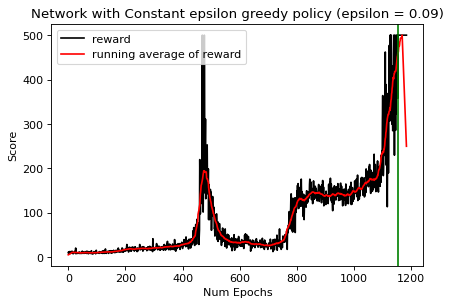

In [ ]:
n = 30
shiftedEpsilonConstan = []
epsilonAverage = np.convolve(np.ones(n),RewardEpsilonConstan)
for i,r in enumerate(epsilonAverage):
    if i>= n/2:
        shiftedEpsilonConstan.append(r/n)
    if i + n/2 == len(epsilonAverage):
        break
plt.figure(figsize=(6,4), dpi=80)
plt.plot(RewardEpsilonConstan,c = 'k',label='reward')
# plt.plot(rc/n)
plt.plot(shiftedEpsilonConstan, c = 'r',label='running average of reward')
plt.xlabel('Num Epochs')
plt.ylabel('Score')
plt.title('Network with Constant epsilon greedy policy (epsilon = 0.09)')
plt.axvline(len(RewardEpsilonConstan) - BreakNum ,c='g')
plt.legend()

## Plot of Softmax and Epsilong greedy output
Here we plotted the running average of all of the last three trial in one plot

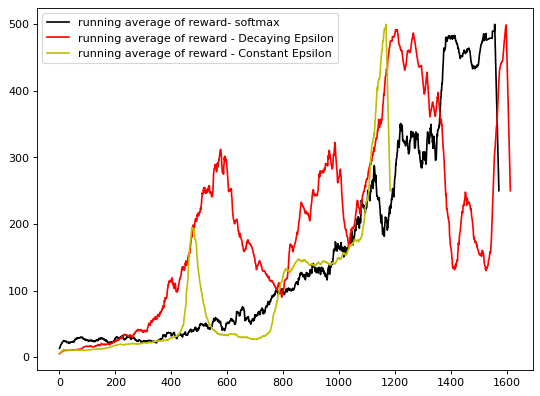

In [ ]:
shifted = shifted[0:2200]
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(shifted,c = 'k',label='running average of reward- softmax')
plt.plot(shiftedEpsilon, c = 'r',label='running average of reward - Decaying Epsilon')
plt.plot(shiftedEpsilonConstan, c = 'y',label='running average of reward - Constant Epsilon')
plt.legend()

# Training loop (advanced)
Let's modify the reward to improve the results.

## Modified Reward funtion and epsilon greedy policy

In [ ]:
lr = 0.01
# torch.manual_seed(40)
replay_mem = ReplayMemory(replay_memory_capacity)    
policy_net = DQN(4, 2)
target_net = DQN(4, 2)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network
loss_fn = nn.SmoothL1Loss()

In [ ]:
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)
RewardAdv = []
for episode_num, tau in enumerate(tqdm(exploration_profile)):
    state = env.reset()
    score = 0
    done = False
    while not done:
        action, q_values = choose_action_epsilon_greedy(policy_net, state,epsilon=0.09)
        next_state, reward, done, info = env.step(action)
        pos_weight = 1
        # angleWeight = 1
        reward = reward - pos_weight * np.abs(state[0])#- angleWeight * np.abs(state[2])/41.8
        score += 1
        if done: # if the pole has fallen down 
            reward += bad_state_penalty
            next_state = None
        replay_mem.push(state, action, next_state, reward)
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)
#         env.render()
        state = next_state
    RewardAdv.append(score)
    if(np.mean(RewardAdv[-BreakNum:]) > 498):
        print("--------------------- break ---------------------")
        break
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
    print(f"EPISODE: {episode_num + 1} - SCORE: {score}") # Print the final score

  0%|          | 0/2200 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - SCORE: 10
EPISODE: 2 - SCORE: 11
EPISODE: 3 - SCORE: 10
EPISODE: 4 - SCORE: 8
EPISODE: 5 - SCORE: 12
EPISODE: 6 - SCORE: 12
EPISODE: 7 - SCORE: 13
EPISODE: 8 - SCORE: 15
EPISODE: 9 - SCORE: 10
EPISODE: 10 - SCORE: 9
Updating target network...
EPISODE: 11 - SCORE: 13
EPISODE: 12 - SCORE: 8
EPISODE: 13 - SCORE: 13
EPISODE: 14 - SCORE: 11
EPISODE: 15 - SCORE: 12
EPISODE: 16 - SCORE: 10
EPISODE: 17 - SCORE: 9
EPISODE: 18 - SCORE: 12
EPISODE: 19 - SCORE: 10
EPISODE: 20 - SCORE: 9
Updating target network...
EPISODE: 21 - SCORE: 11
EPISODE: 22 - SCORE: 9
EPISODE: 23 - SCORE: 10
EPISODE: 24 - SCORE: 9
EPISODE: 25 - SCORE: 10
EPISODE: 26 - SCORE: 10
EPISODE: 27 - SCORE: 10
EPISODE: 28 - SCORE: 13
EPISODE: 29 - SCORE: 14
EPISODE: 30 - SCORE: 9
Updating target network...
EPISODE: 31 - SCORE: 12
EPISODE: 32 - SCORE: 10
EPISODE: 33 - SCORE: 14
EPISODE: 34 - SCORE: 10
EPISODE: 35 - SCORE: 13
EPISODE: 36 - SCORE: 11
EPISODE: 37 - SCORE: 13
EPISODE: 38 - SCORE: 

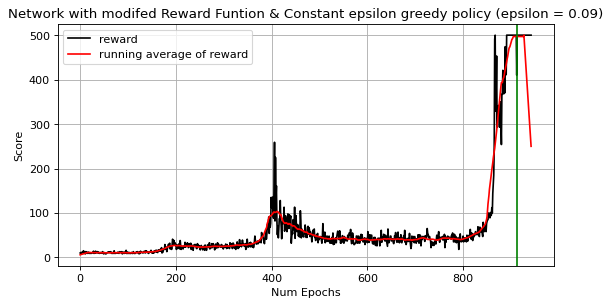

In [ ]:
n = 30
shiftedRewardAdv = []
epsilonAverage = np.convolve(np.ones(n),RewardAdv)
for i,r in enumerate(epsilonAverage):
    if i>= n/2:
        shiftedRewardAdv.append(r/n)
    if i + n/2 == len(epsilonAverage):
        break
plt.figure(figsize=(8,4), dpi=80)
plt.plot(RewardAdv,c = 'k',label='reward')
# plt.plot(rc/n)
plt.plot(shiftedRewardAdv, c = 'r',label='running average of reward')
plt.xlabel('Num Epochs')
plt.ylabel('Score')
plt.title('Network with modifed Reward Funtion & Constant epsilon greedy policy (epsilon = 0.09)')
plt.grid()
plt.axvline(len(RewardAdv) - BreakNum ,c='g')
plt.legend()

In [ ]:
path = 'savedModel.pth'
torch.save(policy_net.state_dict(), path)

## Modified Reward funtion and Softmax policy

In [ ]:
lr = 0.01
replay_mem = ReplayMemory(replay_memory_capacity)    
policy_net = DQN(4, 2)
target_net = DQN(4, 2)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network
loss_fn = nn.SmoothL1Loss()

In [ ]:
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)
RewardAdvSoft = []
for episode_num, tau in enumerate(tqdm(exploration_profile)):
    state = env.reset()
    score = 0
    done = False
    while not done:
        action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
        next_state, reward, done, info = env.step(action)
        pos_weight = 2
        angleWeight = 1
        reward = reward - pos_weight * np.abs(state[0])#- angleWeight * np.abs(state[2])
        score += 1
        if done: # if the pole has fallen down 
            reward += bad_state_penalty
            next_state = None
        replay_mem.push(state, action, next_state, reward)
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)
#         env.render()
        state = next_state
    RewardAdvSoft.append(score)
    if(np.mean(RewardAdvSoft[-BreakNum:]) > 499):
        print("--------------------- break ---------------------")
        break
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
    print(f"EPISODE: {episode_num + 1} -SCORE:{score} ") # Print the final score

  0%|          | 0/2200 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 -SCORE:12 
EPISODE: 2 -SCORE:17 
EPISODE: 3 -SCORE:41 
EPISODE: 4 -SCORE:19 
EPISODE: 5 -SCORE:24 
EPISODE: 6 -SCORE:16 
EPISODE: 7 -SCORE:30 
EPISODE: 8 -SCORE:29 
EPISODE: 9 -SCORE:15 
EPISODE: 10 -SCORE:21 
Updating target network...
EPISODE: 11 -SCORE:31 
EPISODE: 12 -SCORE:59 
EPISODE: 13 -SCORE:29 
EPISODE: 14 -SCORE:26 
EPISODE: 15 -SCORE:18 
EPISODE: 16 -SCORE:14 
EPISODE: 17 -SCORE:17 
EPISODE: 18 -SCORE:27 
EPISODE: 19 -SCORE:20 
EPISODE: 20 -SCORE:21 
Updating target network...
EPISODE: 21 -SCORE:36 
EPISODE: 22 -SCORE:15 
EPISODE: 23 -SCORE:10 
EPISODE: 24 -SCORE:22 
EPISODE: 25 -SCORE:23 
EPISODE: 26 -SCORE:21 
EPISODE: 27 -SCORE:44 
EPISODE: 28 -SCORE:16 
EPISODE: 29 -SCORE:27 
EPISODE: 30 -SCORE:9 
Updating target network...
EPISODE: 31 -SCORE:39 
EPISODE: 32 -SCORE:14 
EPISODE: 33 -SCORE:38 
EPISODE: 34 -SCORE:46 
EPISODE: 35 -SCORE:18 
EPISODE: 36 -SCORE:53 
EPISODE: 37 -SCORE:80 
EPISODE: 38 -SCORE:53 
EPISODE: 39 -SCORE:14 
EPISO

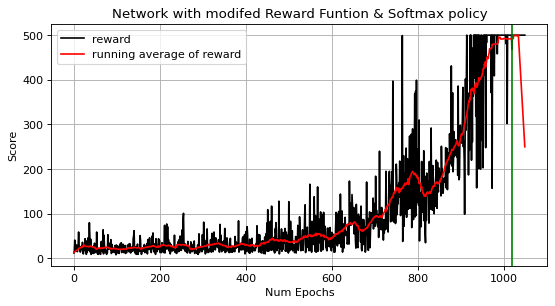

In [ ]:
n = 30
shiftedRewardAdvS = []
epsilonAverage = np.convolve(np.ones(n),RewardAdvSoft)
for i,r in enumerate(epsilonAverage):
    if i>= n/2:
        shiftedRewardAdvS.append(r/n)
    if i + n/2 == len(epsilonAverage):
        break
plt.figure(figsize=(8,4), dpi=80)
plt.plot(RewardAdvSoft,c = 'k',label='reward')
# plt.plot(rc/n)
plt.plot(shiftedRewardAdvS, c = 'r',label='running average of reward')
plt.xlabel('Num Epochs')
plt.ylabel('Score')
plt.title('Network with modifed Reward Funtion & Softmax policy')
plt.grid()
plt.axvline(len(RewardAdvSoft) - BreakNum ,c='g')
plt.legend()

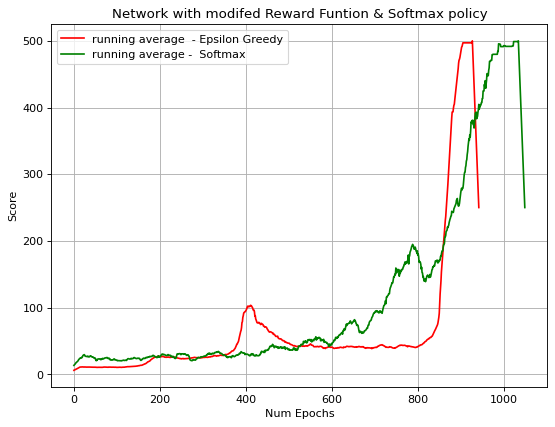

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(shiftedRewardAdv, c = 'r',label='running average  - Epsilon Greedy')
plt.plot(shiftedRewardAdvS,c = 'g',label='running average -  Softmax')
plt.title('Network with modifed Reward Funtion & Softmax policy')
plt.xlabel('Num Epochs')
plt.ylabel('Score')
plt.grid()
plt.legend()

# Final test

In [ ]:
path= "savedModel.pth"

In [ ]:
lr = 0.01
replay_mem = ReplayMemory(replay_memory_capacity)    
policy_net = DQN(4, 2)
policy_net.load_state_dict(torch.load(path))
target_net = DQN(4, 2)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network
loss_fn = nn.SmoothL1Loss()

In [ ]:
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode
scores = []
for num_episode in range(10): 
    state = env.reset()
    score = 0
    done = False
    while not done:
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      next_state, reward, done, info = env.step(action)
      env.render()
      score += reward 
      state = next_state
    # Print the final score
    scores.append(score)
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
print(f"-----------------------------------------------------------") 
print(f"MEAN OF {num_episode + 1} - FINAL SCORE: {np.mean(scores)}") 
print(f"-----------------------------------------------------------") 
env.close()

EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 500.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 500.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 500.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 500.0
-----------------------------------------------------------
MEAN OF 10 - FINAL SCORE: 500.0
-----------------------------------------------------------


In [ ]:
show_video()